In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import block_diag as block_diag_sparse
from scipy.sparse.linalg import eigsh

### 2D Tests

In [2]:
def print_Lattice(state_matrix):
    
    # Define the lattice dimensions and state matrix
    rows, cols = len(state_matrix), len(state_matrix)  # Number of rows and columns
    spacing = 1.0        # Spacing between points

    # Generate lattice points
    x = np.arange(cols) * spacing
    y = np.arange(rows) * spacing
    X, Y = np.meshgrid(x, y)

    # Flatten the grid and state_matrix for easier processing
    x_coords = X.ravel()
    y_coords = Y.ravel()
    states = state_matrix.ravel()

    # Separate points into solid and void based on states
    solid_x = x_coords[states == 1]
    solid_y = y_coords[states == 1]
    void_x = x_coords[states == 0]
    void_y = y_coords[states == 0]

    # Plot the lattice
    plt.figure(figsize=(6, 6))
    plt.scatter(solid_x, solid_y, color='blue', s=50, label='Spin Up')
    plt.scatter(void_x, void_y, color='white', edgecolor='black', s=50, label='Spin Down')
    plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
    plt.title("Lattice with Solid and Void Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    #plt.legend()
    plt.show()

def count_pos(state_num, n):
    if (state_num & 2**n) != 0:
        print("True")
    else:
        print("False")

def num_to_mat(number, bit_width=None):
    """
    Convert a number to a NumPy array of binary digits.
    
    Parameters:
    - number: int, the number to convert.
    - bit_width: int, optional, the desired bit width (pads with zeros if needed).
    
    Returns:
    - np.ndarray: Binary digits as an array.
    """
    if bit_width:
        # Get binary representation with specified width
        binary_string = np.binary_repr(number, width=bit_width**2)
    else:
        # Get binary representation without padding
        binary_string = bin(number)[2:]  # Removes the '0b' prefix
    
    # Convert string to NumPy array of integers
    return np.flip(np.array([int(bit) for bit in binary_string])).reshape((bit_width,bit_width))

def calculate_neighbours_num(state_num, L):
    res = 0
    for i in range(L):
        for j in range(L):
            r =     (i)         * L +   ((j+1) % L)     # right
            l =     (i)         * L +   ((j-1) % L)     # left
            u =     ((i-1) % L) * L +   (j)             # up
            d =     ((i+1) % L) * L +   (j)             # down
            ur =    ((i-1) % L) * L +   ((j+1) % L)     # up-right
            ul =    ((i-1) % L) * L +   ((j-1) % L)     # up-left
            dr =    ((i+1) % L) * L +   ((j+1) % L)     # down-right
            dl =    ((i+1) % L) * L +   ((j-1) % L)     # down-left
            
            res |= int((state_num & 2**(i*L+j))/2**(i*L+j)) * (2**r + 2**l + 2**u + 2**d + 2**ur + 2**ul + 2**dr + 2**dl)
    return res

In [3]:
L = 4
dim = L * L

state = np.array([0]*dim)
state[4] = 1
state[10] = 1
state_num = np.sum(state*2**np.arange(dim))

print(num_to_mat(state_num, L))

[[0 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]


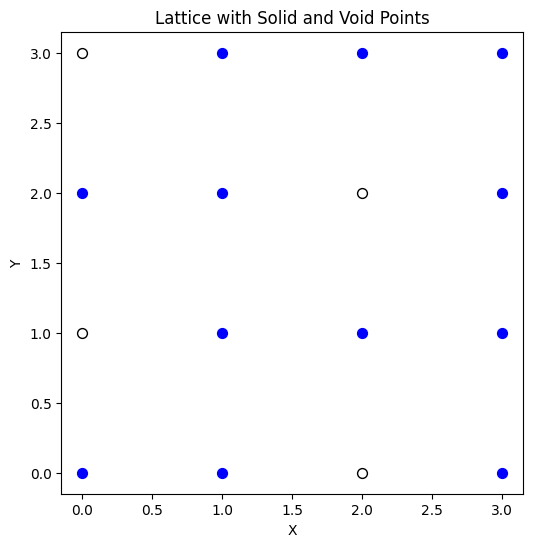

In [4]:
neighbours = calculate_neighbours_num(state_num, L)
print_Lattice(num_to_mat(neighbours, L))

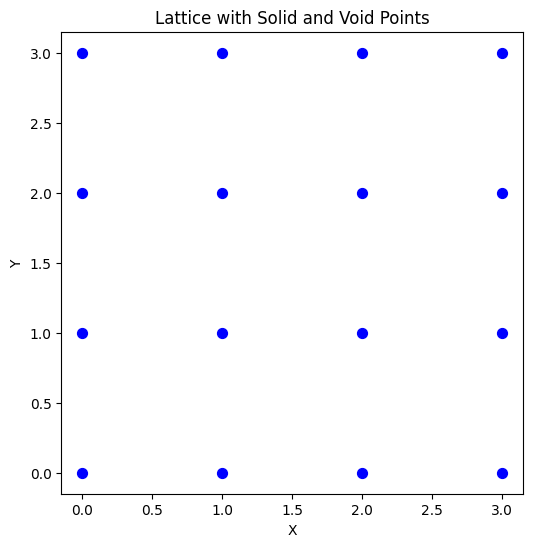

In [5]:
neighbours = calculate_neighbours_num(neighbours, L)
print_Lattice(num_to_mat(neighbours, L))

### 1D Heisenberg

#### Functions

In [2]:
Delta = 1/2

def bit_flip(state, i, j):
    """
    Flip the bits i and j of the state.

    Args:
        state (int): The input state.
        i (int): The first bit to flip.
        j (int): The second bit to flip.
    
    Returns:
        int: The state with the flipped bits.
    """
    return state ^ (2**i + 2**j)


def apply_H(state, L):
    """
    Apply the Hamiltonian to a state.
    
    Args:
        state (int): The input state.
        L (int): The lenght of the system.
        
    Returns:
        list: The list of [coefficient, state].
    """
    output = []
    diag = 0
    for i in range(L):
        nl = (state & 2**(i%L))/2**(i%L)
        nl1 = (state & 2**((i+1)%L))/2**((i+1)%L)
        diag += -Delta/2 * (2*nl - 1) * (2*nl1 - 1)
        if nl != nl1:
            m = bit_flip(state, i%L, (i+1)%L)
            output.append([-1, m])
    output.append([diag,state])
    return output


def build_basisN(L,N):
    """
    Build the basis of states with N particles.
    
    Args:
        L (int): The lenght of the system.
        N (int): The number of particles.
        
    Returns:
        list: The basis of states with N particles.
    """
    basisN = []
    for i in range(2**L):
        binary_representation = np.binary_repr(i, width=L)
        count_1 = binary_representation.count('1')
        if abs(count_1) == N:
            basisN.append(i)
    return basisN   


def build_HN(L,N):
    """
    Build the Hamiltonian matrix for the subspace with L sites and N particles.

    Args:
        L (int): The lenght of the system.
        N (int): The number of particles.

    Returns:
        np.ndarray: The Hamiltonian matrix of the subspace.
    """
    basis = build_basisN(L,N)

    h = np.zeros((len(basis),len(basis)))

    for n in basis:
        i = basis.index(n)
        output = apply_H(n, L)
        for m in output:
            j = basis.index(m[1])
            h[j,i] += m[0]
    return h


def traslate_state(state, L):
    """
    Translate the state to the right with periodic boundary conditions.
    
    Args:
        state (int): The input state.
        L (int): The lenght of the system.

    Returns:
        int: The translated state.
    """
    return state >> 1 | (state & 1) << (L - 1)


def build_basisNK(L,N,k):
    """
    Build the basis of states with N particles and wave number k.

    Args:
        N (int): The number of particles.
        L (int): The lenght of the system.
        k (int): The wave number.

    Returns:
        list: The basis of states with N particles and wave number k.
    """
    basisNK = []
    basisN = build_basisN(L,N)

    periods = []
    ec = []

    for n in basisN:
        nn = n
        for l in range(1,L+1):
            nn = traslate_state(nn,L)
            if nn == n:
                break
        if l in periods:
            ec[periods.index(l)].append(n)
        else:
            periods.append(l)
            ec.append([n])
        
    for i in range(len(periods)):
        if k*periods[i] % L == 0:
            for j in range(len(ec[i])):
                basisNK.append(get_RS(ec[i][j],L)[0])
    


    return list(dict.fromkeys(basisNK))


def check_period(state):
    """
    Check the period of the state.
    
    Args:
        state (int): The input state.
        
    Returns:
        int: The period of the state.
    """

    nn = state
    for l in range(1,L+1):
        nn = traslate_state(nn,L)
        if nn == state:
            break
    return l


def get_RS(n,L):
    """
    Find the rappresentative state and the the translation distance from it.

    Args:
        n (int): The input state.
        L (int): The lenght of the system.
    
    Returns:
        list: The list of [rappresentative state, translation distance].
    """

    min_state = n
    d = 0
    for l in range(1,L):
        n = traslate_state(n, L)
        if n < min_state:
            min_state = n
            d = l
    return [min_state, d]


def build_HNK(L,N,k):
    """
    Build the Hamiltonian matrix for the subspace with L sites, N particles and wave number k.

    Args:
        L (int): The lenght of the system.
        N (int): The number of particles.
        k (int): The wave number.

    Returns:
        np.ndarray: The Hamiltonian matrix of the subspace.
    """
    
    basis = build_basisNK(L,N,k)

    h = np.zeros((len(basis),len(basis)),dtype=complex)

    for n in basis:
        i = basis.index(n)
        yn = np.sqrt(check_period(n))/L
        output = apply_H(n, L)
        for m in output:
            mm,d = get_RS(m[1],L)
            if mm in basis:
                j = basis.index(mm)
                ym = np.sqrt(check_period(mm))/L
                wk = np.exp(2*np.pi*1j*k/L)
                #print(wk, d, wk**d)
                h[j,i] += yn/ym * wk**d * m[0]
    return h

In [3]:
L = 16

#### Full matrix

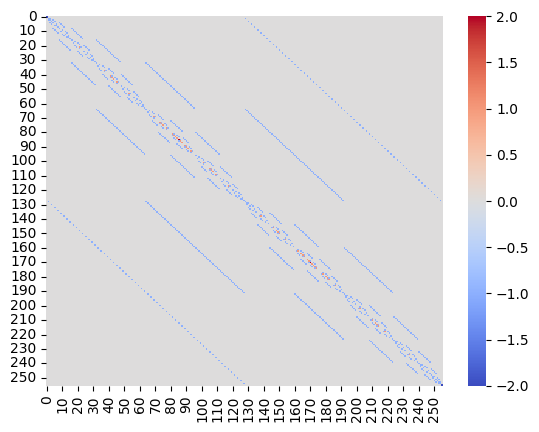

In [8]:
h = np.zeros((2**L,2**L))

for n in range(2**L):
    output = apply_H(n, L)
    for m in output:
        h[n,m[1]] += m[0]

sns.heatmap(h, cmap='coolwarm')#, linecolor='white', linewidth=0.2)
plt.show()

/home/christian/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/christian/.local/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


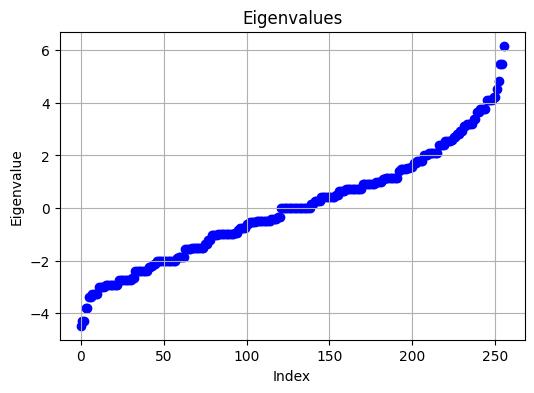

In [9]:
from numpy.linalg import eig

# Diagonalize the matrix h
eigenvalues, eigenvectors = eig(h)

"""print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)"""

plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(eigenvalues)), np.sort(eigenvalues), color='blue')
plt.title('Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

#### Number symmetry

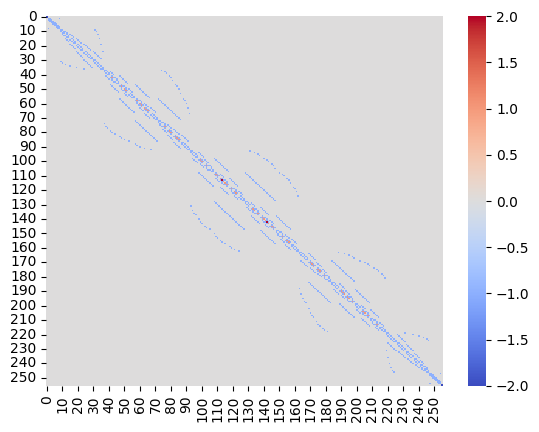

In [13]:
zero = build_HN(L,0)
h = block_diag(zero,build_HN(L,1))
for n in range(2,L+1):
    h=block_diag(h,build_HN(L,n))

sns.heatmap(h, cmap='coolwarm')#, linecolor='white', linewidth=0.2)
plt.show()

/home/christian/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/christian/.local/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


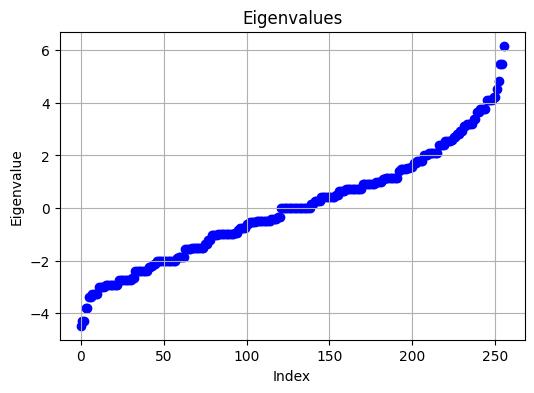

In [14]:
from numpy.linalg import eig

# Diagonalize the matrix h
eigenvalues, eigenvectors = eig(h)

"""print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)"""

plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(eigenvalues)), np.sort(eigenvalues), color='blue')
plt.title('Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

#### Translation symmetry

In [22]:
zero = build_HNK(L,0,0)
h = block_diag(zero,build_HNK(L,1,0))
for k in range(1,L):
    h=block_diag(h,build_HNK(L,1,k))
for n in range(2,L+1):
    for k in range(L):
        h=block_diag(h,build_HNK(L,n,k))

#sns.heatmap(np.abs(h), cmap='coolwarm')#, linecolor='white', linewidth=0.2)
#plt.show()

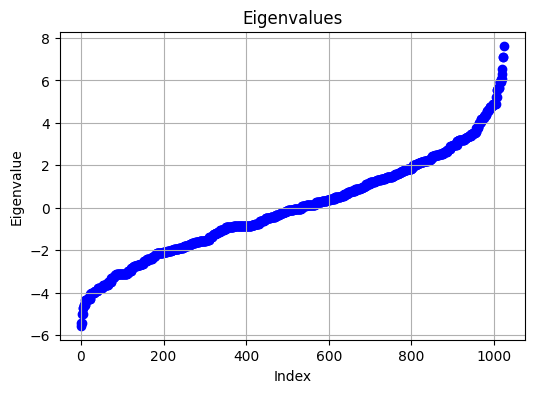

In [23]:
from numpy.linalg import eig

# Diagonalize the matrix h
eigenvalues, eigenvectors = eig(h)

"""print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)"""

plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(eigenvalues)), np.sort(eigenvalues), color='blue')
plt.title('Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [4]:
h_block = []
for n in range(0,L+1):
    for k in range(L):
        h_block.append(build_HNK(L,n,k))
h_sparse = block_diag_sparse(h_block,format='csr')

#sns.heatmap(np.abs(h_sparse.toarray()), cmap='coolwarm')#, linecolor='white', linewidth=0.2)
#plt.show()

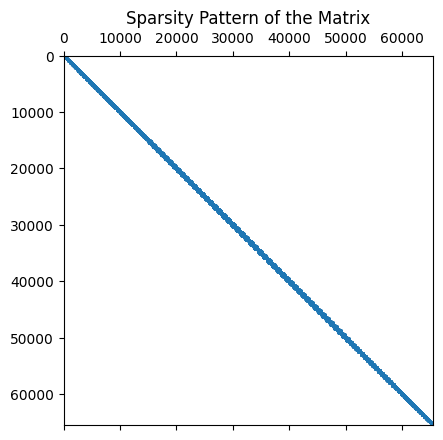

In [5]:
plt.spy(h_sparse, markersize=0.4)  # Visualize sparsity pattern
plt.title("Sparsity Pattern of the Matrix")
plt.show()

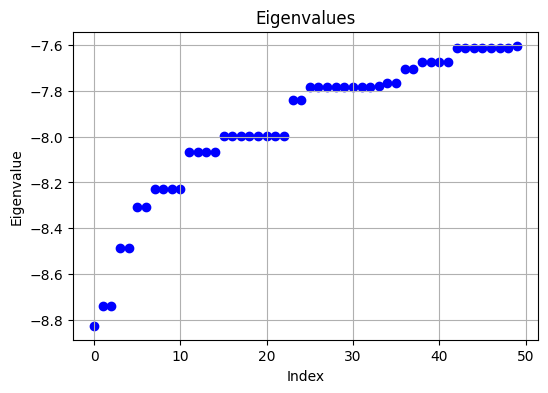

In [6]:
from scipy.sparse.linalg import eigsh

eigenvalues, eigenvectors = eigsh(h_sparse, k=50, which='SA')

plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(eigenvalues)), np.sort(eigenvalues), color='blue')
plt.title('Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()